In [2]:
from google.colab import drive, files
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/DeepLabv3_Delloite/'

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data

from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import io, transform
from scipy.ndimage import distance_transform_edt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time

In [4]:
#@title DRN 
  
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


webroot = 'http://dl.yf.io/drn/'

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'drn-c-26': webroot + 'drn_c_26-ddedf421.pth',
    'drn-c-42': webroot + 'drn_c_42-9d336e8c.pth',
    'drn-c-58': webroot + 'drn_c_58-0a53a92c.pth',
    'drn-d-22': webroot + 'drn_d_22-4bd2f8ea.pth',
    'drn-d-38': webroot + 'drn_d_38-eebb45f0.pth',
    'drn-d-54': webroot + 'drn_d_54-0e0534ff.pth',
    'drn-d-105': webroot + 'drn_d_105-12b40979.pth'}


def conv3x3(in_planes, out_planes, stride=1, padding=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False, dilation=dilation)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 dilation=(1, 1), residual=True, BatchNorm=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride,
                             padding=dilation[0], dilation=dilation[0])
        self.bn1 = BatchNorm(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes,
                             padding=dilation[1], dilation=dilation[1])
        self.bn2 = BatchNorm(planes)
        self.downsample = downsample
        self.stride = stride
        self.residual = residual

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        if self.residual:
            out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 dilation=(1, 1), residual=True, BatchNorm=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=dilation[1], bias=False,
                               dilation=dilation[1])
        self.bn2 = BatchNorm(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class DRN(nn.Module):

    def __init__(self, block, layers, arch='D',
                 channels=(16, 32, 64, 128, 256, 512, 512, 512),
                 BatchNorm=None):
        super(DRN, self).__init__()
        self.inplanes = channels[0]
        self.out_dim = channels[-1]
        self.arch = arch

        if arch == 'C':
            self.conv1 = nn.Conv2d(3, channels[0], kernel_size=7, stride=1,
                                   padding=3, bias=False)
            self.bn1 = BatchNorm(channels[0])
            self.relu = nn.ReLU(inplace=True)

            self.layer1 = self._make_layer(
                BasicBlock, channels[0], layers[0], stride=1, BatchNorm=BatchNorm)
            self.layer2 = self._make_layer(
                BasicBlock, channels[1], layers[1], stride=2, BatchNorm=BatchNorm)

        elif arch == 'D':
            self.layer0 = nn.Sequential(
                nn.Conv2d(3, channels[0], kernel_size=7, stride=1, padding=3,
                          bias=False),
                BatchNorm(channels[0]),
                nn.ReLU(inplace=True)
            )

            self.layer1 = self._make_conv_layers(
                channels[0], layers[0], stride=1, BatchNorm=BatchNorm)
            self.layer2 = self._make_conv_layers(
                channels[1], layers[1], stride=2, BatchNorm=BatchNorm)

        self.layer3 = self._make_layer(block, channels[2], layers[2], stride=2, BatchNorm=BatchNorm)
        self.layer4 = self._make_layer(block, channels[3], layers[3], stride=2, BatchNorm=BatchNorm)
        self.layer5 = self._make_layer(block, channels[4], layers[4],
                                       dilation=2, new_level=False, BatchNorm=BatchNorm)
        self.layer6 = None if layers[5] == 0 else \
            self._make_layer(block, channels[5], layers[5], dilation=4,
                             new_level=False, BatchNorm=BatchNorm)

        if arch == 'C':
            self.layer7 = None if layers[6] == 0 else \
                self._make_layer(BasicBlock, channels[6], layers[6], dilation=2,
                                 new_level=False, residual=False, BatchNorm=BatchNorm)
            self.layer8 = None if layers[7] == 0 else \
                self._make_layer(BasicBlock, channels[7], layers[7], dilation=1,
                                 new_level=False, residual=False, BatchNorm=BatchNorm)
        elif arch == 'D':
            self.layer7 = None if layers[6] == 0 else \
                self._make_conv_layers(channels[6], layers[6], dilation=2, BatchNorm=BatchNorm)
            self.layer8 = None if layers[7] == 0 else \
                self._make_conv_layers(channels[7], layers[7], dilation=1, BatchNorm=BatchNorm)

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            #elif isinstance(m, SynchronizedBatchNorm2d):
                #m.weight.data.fill_(1)
                #m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def _make_layer(self, block, planes, blocks, stride=1, dilation=1,
                    new_level=True, residual=True, BatchNorm=None):
        assert dilation == 1 or dilation % 2 == 0
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = list()
        layers.append(block(
            self.inplanes, planes, stride, downsample,
            dilation=(1, 1) if dilation == 1 else (
                dilation // 2 if new_level else dilation, dilation),
            residual=residual, BatchNorm=BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, residual=residual,
                                dilation=(dilation, dilation), BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def _make_conv_layers(self, channels, convs, stride=1, dilation=1, BatchNorm=None):
        modules = []
        for i in range(convs):
            modules.extend([
                nn.Conv2d(self.inplanes, channels, kernel_size=3,
                          stride=stride if i == 0 else 1,
                          padding=dilation, bias=False, dilation=dilation),
                BatchNorm(channels),
                nn.ReLU(inplace=True)])
            self.inplanes = channels
        return nn.Sequential(*modules)

    def forward(self, x):
        if self.arch == 'C':
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        elif self.arch == 'D':
            x = self.layer0(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.layer3(x)
        low_level_feat = x

        x = self.layer4(x)
        x = self.layer5(x)

        if self.layer6 is not None:
            x = self.layer6(x)

        if self.layer7 is not None:
            x = self.layer7(x)

        if self.layer8 is not None:
            x = self.layer8(x)

        return x, low_level_feat


class DRN_A(nn.Module):

    def __init__(self, block, layers, BatchNorm=None):
        self.inplanes = 64
        super(DRN_A, self).__init__()
        self.out_dim = 512 * block.expansion
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = BatchNorm(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], BatchNorm=BatchNorm)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, BatchNorm=BatchNorm)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                       dilation=2, BatchNorm=BatchNorm)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                       dilation=4, BatchNorm=BatchNorm)

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            #elif isinstance(m, SynchronizedBatchNorm2d):
                #m.weight.data.fill_(1)
                #m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, BatchNorm=BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                dilation=(dilation, dilation, ), BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

#def drn_a_50(BatchNorm, pretrained=True):
#    model = DRN_A(Bottleneck, [3, 4, 6, 3], BatchNorm=BatchNorm)
 #   if pretrained:
#        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
#    return model


def drn_c_26(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 1, 1], arch='C', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-c-26'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_c_42(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 1, 1], arch='C', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-c-42'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_c_58(BatchNorm, pretrained=True):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 1, 1], arch='C', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-c-58'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_22(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 1, 1], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-22'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_24(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 2, 2, 2, 2, 2, 2], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-24'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_38(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 1, 1], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-38'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_40(BatchNorm, pretrained=True):
    model = DRN(BasicBlock, [1, 1, 3, 4, 6, 3, 2, 2], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-40'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_54(BatchNorm, pretrained=True):
    model = DRN(Bottleneck, [1, 1, 3, 4, 6, 3, 1, 1], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-54'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model


def drn_d_105(BatchNorm, pretrained=True):
    model = DRN(Bottleneck, [1, 1, 3, 4, 23, 3, 1, 1], arch='D', BatchNorm=BatchNorm)
    if pretrained:
        pretrained = model_zoo.load_url(model_urls['drn-d-105'])
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        model.load_state_dict(pretrained)
    return model

if __name__ == "__main__":
    import torch
    model = drn_c_26(BatchNorm=nn.BatchNorm2d, pretrained=True)
    input = torch.rand(1, 3, 512, 512)
    output, low_level_feat = model(input)
    print(output.size())
    print(low_level_feat.size())

Downloading: "http://dl.yf.io/drn/drn_c_26-ddedf421.pth" to /root/.cache/torch/hub/checkpoints/drn_c_26-ddedf421.pth



torch.Size([1, 512, 64, 64])
torch.Size([1, 64, 128, 128])


In [5]:
#@title Resnet

import math
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, BatchNorm=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               dilation=dilation, padding=dilation, bias=False)
        self.bn2 = BatchNorm(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, output_stride, BatchNorm, pretrained=True):
        self.inplanes = 64
        super(ResNet, self).__init__()
        blocks = [1, 2, 4]
        if output_stride == 16:
            strides = [1, 2, 2, 1]
            dilations = [1, 1, 1, 2]
        elif output_stride == 8:
            strides = [1, 2, 1, 1]
            dilations = [1, 1, 2, 4]
        else:
            raise NotImplementedError

        # Modules
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                bias=False)
        self.bn1 = BatchNorm(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], dilation=dilations[0], BatchNorm=BatchNorm)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.layer4 = self._make_MG_unit(block, 512, blocks=blocks, stride=strides[3], dilation=dilations[3], BatchNorm=BatchNorm)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=strides[3], dilation=dilations[3], BatchNorm=BatchNorm)
        self._init_weight()

        if pretrained:
            self._load_pretrained_model()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation, downsample, BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def _make_MG_unit(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=blocks[0]*dilation,
                            downsample=downsample, BatchNorm=BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1,
                                dilation=blocks[i]*dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        low_level_feat = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            #elif isinstance(m, SynchronizedBatchNorm2d):
           #     m.weight.data.fill_(1)
            #    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('https://download.pytorch.org/models/resnet101-5d3b4d8f.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

def ResNet101(output_stride, BatchNorm, pretrained=True):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], output_stride, BatchNorm, pretrained=pretrained)
    return model

if __name__ == "__main__":
    import torch
    model = ResNet101(BatchNorm=nn.BatchNorm2d, pretrained=True, output_stride=8)
    input = torch.rand(1, 3, 512, 512)
    output, low_level_feat = model(input)
    print(output.size())
    print(low_level_feat.size())

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



torch.Size([1, 2048, 64, 64])
torch.Size([1, 256, 128, 128])


In [6]:
#@title Mobilenet

import torch
import torch.nn.functional as F
import torch.nn as nn
import math
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d
import torch.utils.model_zoo as model_zoo

def conv_bn(inp, oup, stride, BatchNorm):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        BatchNorm(oup),
        nn.ReLU6(inplace=True)
    )


def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, dilation, expand_ratio, BatchNorm):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup
        self.kernel_size = 3
        self.dilation = dilation

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 0, dilation, groups=hidden_dim, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, 1, 1, bias=False),
                BatchNorm(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, 1, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 0, dilation, groups=hidden_dim, bias=False),
                BatchNorm(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, 1, bias=False),
                BatchNorm(oup),
            )

    def forward(self, x):
        x_pad = fixed_padding(x, self.kernel_size, dilation=self.dilation)
        if self.use_res_connect:
            x = x + self.conv(x_pad)
        else:
            x = self.conv(x_pad)
        return x


class MobileNetV2(nn.Module):
    def __init__(self, output_stride=8, BatchNorm=None, width_mult=1., pretrained=True):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        current_stride = 1
        rate = 1
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = int(input_channel * width_mult)
        self.features = [conv_bn(3, input_channel, 2, BatchNorm)]
        current_stride *= 2
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            if current_stride == output_stride:
                stride = 1
                dilation = rate
                rate *= s
            else:
                stride = s
                dilation = 1
                current_stride *= s
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, stride, dilation, t, BatchNorm))
                else:
                    self.features.append(block(input_channel, output_channel, 1, dilation, t, BatchNorm))
                input_channel = output_channel
        self.features = nn.Sequential(*self.features)
        self._initialize_weights()

        if pretrained:
            self._load_pretrained_model()

        self.low_level_features = self.features[0:4]
        self.high_level_features = self.features[4:]

    def forward(self, x):
        low_level_feat = self.low_level_features(x)
        x = self.high_level_features(low_level_feat)
        return x, low_level_feat

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('http://jeff95.me/models/mobilenet_v2-6a65762b.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
 #           elif isinstance(m, SynchronizedBatchNorm2d):
  #              m.weight.data.fill_(1)
  #              m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

if __name__ == "__main__":
    input = torch.rand(1, 3, 512, 512)
    model = MobileNetV2(output_stride=16, BatchNorm=nn.BatchNorm2d)
    output, low_level_feat = model(input)
    print(output.size())
    print(low_level_feat.size())

Downloading: "http://jeff95.me/models/mobilenet_v2-6a65762b.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-6a65762b.pth



torch.Size([1, 320, 32, 32])
torch.Size([1, 24, 128, 128])


In [7]:
#@title Xception

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs


class SeparableConv2d(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, dilation=1, bias=False, BatchNorm=None):
        super(SeparableConv2d, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, inplanes, kernel_size, stride, 0, dilation,
                               groups=inplanes, bias=bias)
        self.bn = BatchNorm(inplanes)
        self.pointwise = nn.Conv2d(inplanes, planes, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = fixed_padding(x, self.conv1.kernel_size[0], dilation=self.conv1.dilation[0])
        x = self.conv1(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self, inplanes, planes, reps, stride=1, dilation=1, BatchNorm=None,
                 start_with_relu=True, grow_first=True, is_last=False):
        super(Block, self).__init__()

        if planes != inplanes or stride != 1:
            self.skip = nn.Conv2d(inplanes, planes, 1, stride=stride, bias=False)
            self.skipbn = BatchNorm(planes)
        else:
            self.skip = None

        self.relu = nn.ReLU(inplace=True)
        rep = []

        filters = inplanes
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(inplanes, planes, 3, 1, dilation, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))
            filters = planes

        for i in range(reps - 1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters, filters, 3, 1, dilation, BatchNorm=BatchNorm))
            rep.append(BatchNorm(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(inplanes, planes, 3, 1, dilation, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))

        if stride != 1:
            rep.append(self.relu)
            rep.append(SeparableConv2d(planes, planes, 3, 2, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))

        if stride == 1 and is_last:
            rep.append(self.relu)
            rep.append(SeparableConv2d(planes, planes, 3, 1, BatchNorm=BatchNorm))
            rep.append(BatchNorm(planes))

        if not start_with_relu:
            rep = rep[1:]

        self.rep = nn.Sequential(*rep)

    def forward(self, inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x = x + skip

        return x


class AlignedXception(nn.Module):
    """
    Modified Alighed Xception
    """
    def __init__(self, output_stride, BatchNorm,
                 pretrained=True):
        super(AlignedXception, self).__init__()

        if output_stride == 16:
            entry_block3_stride = 2
            middle_block_dilation = 1
            exit_block_dilations = (1, 2)
        elif output_stride == 8:
            entry_block3_stride = 1
            middle_block_dilation = 2
            exit_block_dilations = (2, 4)
        else:
            raise NotImplementedError


        # Entry flow
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = BatchNorm(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        self.bn2 = BatchNorm(64)

        self.block1 = Block(64, 128, reps=2, stride=2, BatchNorm=BatchNorm, start_with_relu=False)
        self.block2 = Block(128, 256, reps=2, stride=2, BatchNorm=BatchNorm, start_with_relu=False,
                            grow_first=True)
        self.block3 = Block(256, 728, reps=2, stride=entry_block3_stride, BatchNorm=BatchNorm,
                            start_with_relu=True, grow_first=True, is_last=True)

        # Middle flow
        self.block4  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block5  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block6  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block7  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block8  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block9  = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block10 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block11 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block12 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block13 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block14 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block15 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block16 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block17 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block18 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)
        self.block19 = Block(728, 728, reps=3, stride=1, dilation=middle_block_dilation,
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=True)

        # Exit flow
        self.block20 = Block(728, 1024, reps=2, stride=1, dilation=exit_block_dilations[0],
                             BatchNorm=BatchNorm, start_with_relu=True, grow_first=False, is_last=True)

        self.conv3 = SeparableConv2d(1024, 1536, 3, stride=1, dilation=exit_block_dilations[1], BatchNorm=BatchNorm)
        self.bn3 = BatchNorm(1536)

        self.conv4 = SeparableConv2d(1536, 1536, 3, stride=1, dilation=exit_block_dilations[1], BatchNorm=BatchNorm)
        self.bn4 = BatchNorm(1536)

        self.conv5 = SeparableConv2d(1536, 2048, 3, stride=1, dilation=exit_block_dilations[1], BatchNorm=BatchNorm)
        self.bn5 = BatchNorm(2048)

        # Init weights
        self._init_weight()

        # Load pretrained model
        if pretrained:
            self._load_pretrained_model()

    def forward(self, x):
        # Entry flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        # add relu here
        x = self.relu(x)
        low_level_feat = x
        x = self.block2(x)
        x = self.block3(x)

        # Middle flow
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        x = self.block13(x)
        x = self.block14(x)
        x = self.block15(x)
        x = self.block16(x)
        x = self.block17(x)
        x = self.block18(x)
        x = self.block19(x)

        # Exit flow
        x = self.block20(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)

        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            #elif isinstance(m, SynchronizedBatchNorm2d):
               # m.weight.data.fill_(1)
               # m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('http://data.lip6.fr/cadene/pretrainedmodels/xception-b5690688.pth')
        model_dict = {}
        state_dict = self.state_dict()

        for k, v in pretrain_dict.items():
            if k in state_dict:
                if 'pointwise' in k:
                    v = v.unsqueeze(-1).unsqueeze(-1)
                if k.startswith('block11'):
                    model_dict[k] = v
                    model_dict[k.replace('block11', 'block12')] = v
                    model_dict[k.replace('block11', 'block13')] = v
                    model_dict[k.replace('block11', 'block14')] = v
                    model_dict[k.replace('block11', 'block15')] = v
                    model_dict[k.replace('block11', 'block16')] = v
                    model_dict[k.replace('block11', 'block17')] = v
                    model_dict[k.replace('block11', 'block18')] = v
                    model_dict[k.replace('block11', 'block19')] = v
                elif k.startswith('block12'):
                    model_dict[k.replace('block12', 'block20')] = v
                elif k.startswith('bn3'):
                    model_dict[k] = v
                    model_dict[k.replace('bn3', 'bn4')] = v
                elif k.startswith('conv4'):
                    model_dict[k.replace('conv4', 'conv5')] = v
                elif k.startswith('bn4'):
                    model_dict[k.replace('bn4', 'bn5')] = v
                else:
                    model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)



if __name__ == "__main__":
    import torch
    model = AlignedXception(BatchNorm=nn.BatchNorm2d, pretrained=False, output_stride=16)
    input = torch.rand(1, 3, 512, 512)
    output, low_level_feat = model(input)
    print(output.size())
    print(low_level_feat.size())

torch.Size([1, 2048, 32, 32])
torch.Size([1, 128, 128, 128])


In [8]:
#@title ASPP

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, BatchNorm):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = BatchNorm(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            #elif isinstance(m, SynchronizedBatchNorm2d):
             #   m.weight.data.fill_(1)
              #  m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, backbone, output_stride, BatchNorm):
        super(ASPP, self).__init__()
        if backbone == 'drn':
            inplanes = 512
        elif backbone == 'mobilenet':
            inplanes = 320
        else:
            inplanes = 2048
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = _ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
        self.aspp2 = _ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.aspp3 = _ASPPModule(inplanes, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.aspp4 = _ASPPModule(inplanes, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, 256, 1, stride=1, bias=False),
                                             BatchNorm(256),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = BatchNorm(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self._init_weight()

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            #elif isinstance(m, SynchronizedBatchNorm2d):
                #m.weight.data.fill_(1)
               # m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def build_aspp(backbone, output_stride, BatchNorm):
    return ASPP(backbone, output_stride, BatchNorm)

In [9]:
#@title Decoder

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

class Decoder(nn.Module):
    def __init__(self, num_classes, backbone, BatchNorm):
        super(Decoder, self).__init__()
        if backbone == 'resnet' or backbone == 'drn':
            low_level_inplanes = 256
        elif backbone == 'xception':
            low_level_inplanes = 128
        elif backbone == 'mobilenet':
            low_level_inplanes = 24
        else:
            raise NotImplementedError

        self.conv1 = nn.Conv2d(low_level_inplanes, 48, 1, bias=False)
        self.bn1 = BatchNorm(48)
        self.relu = nn.ReLU()
        self.last_conv = nn.Sequential(nn.Conv2d(304, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Conv2d(256, num_classes, kernel_size=1, stride=1))
        self._init_weight()


    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)
        x = self.last_conv(x)

        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            #elif isinstance(m, SynchronizedBatchNorm2d):
             #   m.weight.data.fill_(1)
              #  m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def build_decoder(num_classes, backbone, BatchNorm):
    return Decoder(num_classes, backbone, BatchNorm)

In [10]:
#@title Build backbone

def build_backbone(backbone, output_stride, BatchNorm):
    if backbone == 'resnet':
        return ResNet101(output_stride, BatchNorm)
    elif backbone == 'xception':
        return AlignedXception(output_stride, BatchNorm)
    elif backbone == 'drn':
        return drn_d_38(BatchNorm=nn.BatchNorm2d,  pretrained=True)
    elif backbone == 'mobilenet':
        return MobileNetV2(output_stride, BatchNorm)
    else:
        raise NotImplementedError

In [11]:
#@title DeepLab

import torch
import torch.nn as nn
import torch.nn.functional as F
#from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d
#from modeling.aspp import build_aspp
#from modeling.decoder import build_decoder
#from modeling.backbone import build_backbone

class DeepLab(nn.Module):
    def __init__(self, backbone='resnet', output_stride=16, num_classes=21,
                 sync_bn=True, freeze_bn=False):
        super(DeepLab, self).__init__()
        if backbone == 'drn':
            output_stride = 8

        #if sync_bn == True:
           # BatchNorm = SynchronizedBatchNorm2d
        #else:
            #BatchNorm = nn.BatchNorm2d

        BatchNorm = nn.BatchNorm2d

        self.backbone = build_backbone(backbone, output_stride, BatchNorm)
        self.aspp = build_aspp(backbone, output_stride, BatchNorm)
        self.decoder = build_decoder(num_classes, backbone, BatchNorm)

        self.freeze_bn = freeze_bn

    def forward(self, input):

        input=input.type(torch.FloatTensor)
        x, low_level_feat = self.backbone(input)
        x = self.aspp(x)
        x = self.decoder(x, low_level_feat)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def freeze_bn(self):
        for m in self.modules():
            m.eval()
            #if isinstance(m, SynchronizedBatchNorm2d):
                #m.eval()
            #elif isinstance(m, nn.BatchNorm2d):
                #m.eval()

    def get_1x_lr_params(self):
        modules = [self.backbone]
        for i in range(len(modules)):
            for m in modules[i].named_modules():
                if self.freeze_bn:
                    if isinstance(m[1], nn.Conv2d):
                        for p in m[1].parameters():
                            if p.requires_grad:
                                yield p
                else:
                  if isinstance(m[1], nn.Conv2d) or isinstance(m[1], nn.BatchNorm2d):       
                    #if isinstance(m[1], nn.Conv2d) or isinstance(m[1], SynchronizedBatchNorm2d) \
                            #or isinstance(m[1], nn.BatchNorm2d):
                        for p in m[1].parameters():
                            if p.requires_grad:
                                yield p

    def get_10x_lr_params(self):
        modules = [self.aspp, self.decoder]
        for i in range(len(modules)):
            for m in modules[i].named_modules():
                if self.freeze_bn:
                    if isinstance(m[1], nn.Conv2d):
                        for p in m[1].parameters():
                            if p.requires_grad:
                                yield p
                else:
                    if isinstance(m[1], nn.Conv2d) or isinstance(m[1], nn.BatchNorm2d):        
                    #if isinstance(m[1], nn.Conv2d) or isinstance(m[1], SynchronizedBatchNorm2d) \
                        #    or isinstance(m[1], nn.BatchNorm2d):
                        for p in m[1].parameters():
                            if p.requires_grad:
                                yield p

#if __name__ == "__main__":
#    model = DeepLab(backbone='mobilenet', output_stride=16).cuda()
  #  model.eval()
 #   input = torch.rand(1, 3, 400, 400)
 #   input=Variable(input.type(torch.cuda.FloatTensor)).cuda()
   
  #  output = model(input)
 #   print(output.size())
#model=DeepLab(backbone='mobilenet', output_stride=16)
#for param in model.parameters():
#    print(param.data)


In [12]:
#@title Build Losses
def build_losses(losses):
    if losses == 'WCE':
        return WeightedCrossEntropyLoss()
    elif losses == 'Dice loss':
        return SoftDiceLoss()
    elif losses == 'Dice_CE':
        return DC_and_CE_loss({'batch_dice': False, 'smooth': 1e-5, 'do_bg': True, 'square': True},{})
    else:
        raise NotImplementedError

In [13]:
#@title dice loss delloitte 
import torch

from torch.nn import functional as F

def dice_loss(true, logits, ignore_background=False, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
        
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))

    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)

    if ignore_background:
        dice_loss = (2. * intersection[1:] / (cardinality[1:] + eps))
    else:
        dice_loss = (2. * intersection / (cardinality + eps))
    return  dice_loss


In [14]:
#@title Pixel Accuracy

def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)
    sum_n_ii = 0
    sum_t_i  = 0


    for i in list(range(0,n_cl)):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)

 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl[1:]):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
 
        if (t_i != 0):
            accuracy[i] = n_ii / t_i

    mean_accuracy_ = np.mean(accuracy)
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)
    _, n_cl_gt = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)
 
    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)
    
    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

'''
Exceptions
'''
class EvalSegErr(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)


def multi_acc(pred, label):
    _, tags = torch.max(pred, dim = 1)
    corrects = (tags == label).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    return acc

In [15]:
#@title Radam
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class RAdam_4step(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, update_all=False, additional_four=False):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.update_all = update_all # whether update the first 4 steps
        self.additional_four = additional_four # whether use additional 4 steps for SGD
        self.buffer = [[None, None] for ind in range(10)]
        super(RAdam_4step, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_4step, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam_4step does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = -4 if self.additional_four else 0 #since this exp requires exactly 4 step, it is hard coded 
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                if state['step'] > 0:

                    state_step = state['step'] + 4 if self.additional_four else state['step'] #since this exp requires exactly 4 step, it is hard coded 

                    buffered = self.buffer[int(state_step % 10)]
                    if state_step == buffered[0]:
                        step_size = buffered[1]
                    else:
                        buffered[0] = state_step
                        beta2_t = beta2 ** state['step']

                        if state['step'] > 4: #since this exp requires exactly 4 step, it is hard coded 
                            N_sma_max = 2 / (1 - beta2) - 1
                            N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                            step_size = group['lr'] * math.sqrt((N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state_step)
                        elif  self.update_all:
                            step_size = group['lr'] / (1 - beta1 ** state_step)
                        else:
                            step_size = 0
                        buffered[1] = step_size

                    if state['step'] > 4: #since this exp requires exactly 4 step, it is hard coded 
                        if group['weight_decay'] != 0:
                            p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                        denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state_step)).add_(group['eps'])
                        p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                        p.data.copy_(p_data_fp32)
                    elif self.update_all:
                        if group['weight_decay'] != 0:
                            p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                        denom = (exp_avg_sq.sqrt() / math.sqrt(1 - beta2 ** state_step)) 
                        p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                        p.data.copy_(p_data_fp32)
                else:
                    state_step = state['step'] + 4 if self.additional_four else state['step'] #since this exp requires exactly 4 step, it is hard coded 

                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * 0.1, p_data_fp32)

                    step_size = 0.1 / (1 - beta1 ** state_step)
                    p_data_fp32.add_(-step_size, exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, use_variance=True, warmup = 4000):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, use_variance=True, warmup = warmup)
        print('======== Warmup: {} ========='.format(warmup))
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        global iter_idx
        iter_idx += 1
        grad_list = list()
        mom_list = list()
        mom_2rd_list = list()

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-6 + state['step'] * (group['lr'] - 1e-6) / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = scheduled_lr * math.sqrt(bias_correction2) / bias_correction1
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [16]:
#@title Dice Loss

def softmax_helper(x):
    # copy from: https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunet/utilities/nd_softmax.py
    rpt = [1 for _ in range(len(x.size()))]
    rpt[1] = x.size(1)
    x_max = x.max(1, keepdim=True)[0].repeat(*rpt)
    e_x = torch.exp(x - x_max)
    return e_x / e_x.sum(1, keepdim=True).repeat(*rpt)

def sum_tensor(inp, axes, keepdim=False):
    # copy from: https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunet/utilities/tensor_utilities.py
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp

def get_tp_fp_fn(net_output, gt, axes=None, mask=None, square=False):
    """
    net_output must be (b, c, x, y(, z)))
    gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
    if mask is provided it must have shape (b, 1, x, y(, z)))
    :param net_output:
    :param gt:
    :param axes:
    :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
    :param square: if True then fp, tp and fn will be squared before summation
    :return:
    """
    if axes is None:
        axes = tuple(range(2, len(net_output.size())))

    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)

    tp = net_output * y_onehot
    fp = net_output * (1 - y_onehot)
    fn = (1 - net_output) * y_onehot

    if mask is not None:
        tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
        fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
        fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)

    if square:
        tp = tp ** 2
        fp = fp ** 2
        fn = fn ** 2

    tp = sum_tensor(tp, axes, keepdim=False)
    fp = sum_tensor(fp, axes, keepdim=False)
    fn = sum_tensor(fn, axes, keepdim=False)

    return tp, fp, fn

class SoftDiceLoss(nn.Module):
    def __init__(self, apply_nonlin=softmax_helper, batch_dice=False, do_bg=True, smooth=1.,
                 square=False):
        """
        paper: https://arxiv.org/pdf/1606.04797.pdf
        """
        super(SoftDiceLoss, self).__init__()

        self.square = square
        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)

        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)

        if not self.do_bg:
            if self.batch_dice:
                dc = dc[1:]
            else:
                dc = dc[:, 1:]
        dc = dc

        return dc

class IoULoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.,
                 square=False):
        """
        paper: https://link.springer.com/chapter/10.1007/978-3-319-50835-1_22
        
        """
        super(IoULoss, self).__init__()

        self.square = square
        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)


        iou = (tp + self.smooth) / (tp + fp + fn + self.smooth)

        if not self.do_bg:
            if self.batch_dice:
                iou = iou[1:]
            else:
                iou = iou[:, 1:]
        iou = iou.mean()

        return iou


car shape : (256, 256, 3)
mask shape : (256, 256)
mask classes : [0 1 2 3 6 7 8]
torch.Size([1, 3, 256, 256])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)


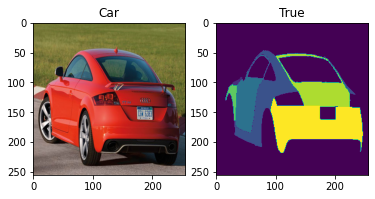

car shape : (256, 256, 3)
mask shape : (256, 256)
mask classes : [0 1 2 3 4 6 8]
torch.Size([1, 3, 256, 256])


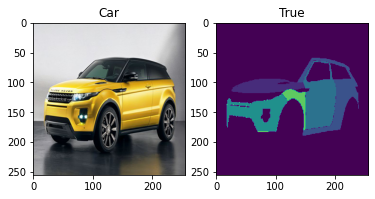

car shape : (256, 256, 3)
mask shape : (256, 256)
mask classes : [0 2 3 5 6 7 8]
torch.Size([1, 3, 256, 256])


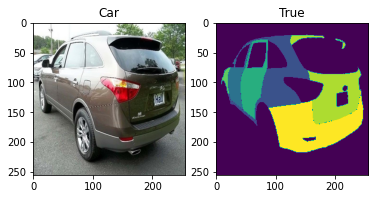

car shape : (256, 256, 3)
mask shape : (256, 256)
mask classes : [0 1 2 3 4 5 6 8]
torch.Size([1, 3, 256, 256])


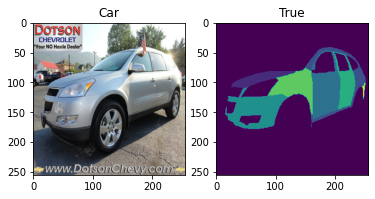

car shape : (256, 256, 3)
mask shape : (256, 256)
mask classes : [0 1 2 3 5 6 7 8]
torch.Size([1, 3, 256, 256])


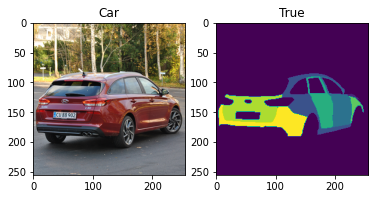

car shape : (256, 256, 3)
mask shape : (256, 256)
mask classes : [0 1 2 3 4 5 6 8]
torch.Size([1, 3, 256, 256])


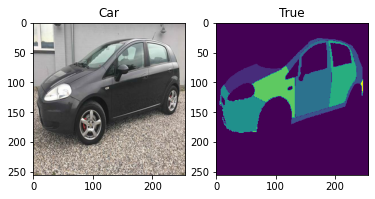

car shape : (256, 256, 3)
mask shape : (256, 256)
mask classes : [0 2 3 4 5 6 7 8]
torch.Size([1, 3, 256, 256])


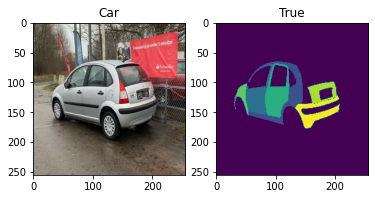

car shape : (256, 256, 3)
mask shape : (256, 256)
mask classes : [0 1 2 3 4 5 6 8]
torch.Size([1, 3, 256, 256])


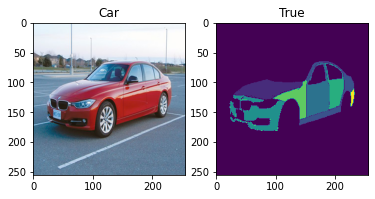

In [17]:
#@title Opening test photos
from numpy import savetxt
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path1_test = drive_path+'carseg_data/turtle_dataset/Provisional_Data/test_set/test_cars/'
path2_test = drive_path+'carseg_data/turtle_dataset/Provisional_Data/test_set/test_masks/'

test_cars = sorted(os.listdir(path1_test))
test_masks = sorted(os.listdir(path2_test))

resized_cars, cars, masks, tis = [], [], [], []
for i in range(len(test_cars)):
  image_ti = Image.open(path1_test + test_cars[i])
  image_ma = Image.open(path2_test + test_masks[i])

  height, width = 256, 256

  image_ti = image_ti.resize((256, 256), resample=1)
  resized_cars.append(image_ti)

  # if image_type == 'HSV':             
  #     image_t=image_ti.convert('HSV')
  #     image_test = np.asarray(image_t)

  # if image_type == 'RGB':
  # #  image_test = np.asarray(image_ti)[:,:,:3]
  #     image_t = np.asarray(image_ti) / 255
  #     img_inp = np.zeros_like(image_t)
  #     img_inp[ :, :, 0] = (image_t[:, :, 0] - r_mean) / r_std
  #     img_inp[ :, :, 1] = (image_t[:, :, 1] - g_mean) / g_std
  #     img_inp[ :, :, 2] = (image_t[:, :, 2] - b_mean) / b_std
  #     image_test = img_inp[:,:,:3] #this one just for RBGA cases

  image_ti = np.asarray(image_ti)      

  image_ma = image_ma.resize((256, 256), Image.NEAREST)
  image_ma2 = np.asarray(image_ma)  
  print('car shape :',image_ti.shape)
  print('mask shape :',image_ma2.shape)
  print('mask classes :',np.unique(image_ma2))

  img_inp = torch.from_numpy(image_ti)
  imgs=torch.transpose(img_inp,0,2)
  imgs=torch.transpose(imgs,1,2)
  imgs=torch.reshape(imgs, (1,3,256,256))
  print(imgs.shape)
  imgs_test = Variable(imgs.type(torch.FloatTensor))

  cars.append(imgs_test)
  masks.append(image_ma2)
  tis.append(image_ti)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(image_ti)
  ax.set_title('Car')
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(image_ma2)
  ax.set_title('True')
  plt.show()

In [18]:
#@title Load net and print for one image
backbone ='resnet'
ligenu = 'ADAMW_'
network = DeepLab(backbone=backbone, output_stride=16) ####################3

#network.load_state_dict(torch.load(drive_path+'model2.pth'))

#checkpoint = torch.load( drive_path + ligenu + 'BEST_loss_checkpoint_' + backbone + '_WCE.pth.tar')##########################
#checkpoint = torch.load( drive_path + 'carseg_data/turtle_dataset/checkpoint_resnet_WCE_8.pth.tar')
checkpoint = torch.load( drive_path +'best_checkpoint_resnet_WCEHSV_ungly.pth')

network.load_state_dict(checkpoint['model_state_dict'])
#network =checkpoint['network'].cpu()                                 
#network.load_state_dict(checkpoint['model_state_dict'])

#network.load_state_dict(checkpoint['model_state_dict'])

#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

network.eval()
img_name='Parkering.jpg'###########################

#img_name='Delloite.PNG'
mask_name='1coche_mask.png'
image_ti = Image.open(drive_path+img_name)
image_ti = image_ti.resize((256, 256), Image.NEAREST)
image_t = image_ti.convert('HSV')
image_t = np.asarray(image_t)
#image_t = image_t[:,:,:3] #this one just for RBGA cases
#image_t = image_t / 255

image_ma = Image.open(drive_path+mask_name)
image_ma = image_ma.resize((256, 256), Image.NEAREST)
image_ma2 = np.asarray(image_ma)  
print(image_ma2.shape)
print('mira mask',np.unique(image_ma2))

#img_inp = np.zeros_like(image_t)

#img_inp[ :, :, 0] = image_t[:, :, 0] - 0.485 / 0.229
#img_inp[ :, :, 1] = image_t[:, :, 1] - 0.456 / 0.224
#img_inp[ :, :, 2] = image_t[:, :, 2] - 0.406 / 0.225

img_inp = torch.from_numpy(image_t)
print(img_inp.shape)
imgs=torch.transpose(img_inp,0,2)
imgs=torch.transpose(imgs,1,2)
imgs=torch.reshape(imgs, (1,3,256,256))
print(imgs.shape)
imgs = Variable(imgs.type(torch.FloatTensor))
print(imgs.shape)

FileNotFoundError: ignored

In [19]:
#@title Dice coeficient
def dice_coeff(im1, im2, empty_score=1.0):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() / im_sum)

soft dice: tensor([[0.9376, 0.0155, 0.6374, 0.7816, 0.0016, 0.0011, 0.4921, 0.6121, 0.6663]],
       grad_fn=<DivBackward0>) <class 'torch.Tensor'>
Pixel accuracy (only the car): 85.87493896484375  %
dice beauty: 0.8652767866245284
Classes ground true: [0 1 2 3 4 5 6 8]
Classes predicted:  [0 2 3 4 5 6 7 8]


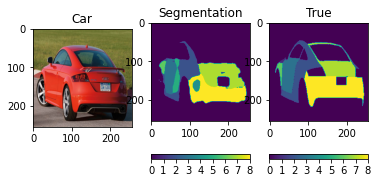

[0 2 3 4 5 6 7 8]
soft dice: tensor([[9.5880e-01, 8.2898e-01, 3.8028e-01, 8.3543e-01, 6.9866e-01, 8.4060e-04,
         6.2884e-01, 5.0546e-02, 1.5953e-02]], grad_fn=<DivBackward0>) <class 'torch.Tensor'>
Pixel accuracy (only the car): 91.02325439453125  %
dice beauty: 0.8443859229111803
Classes ground true: [0 1 2 3 4 5 6 8]
Classes predicted:  [0 1 2 3 4 5 6 8]


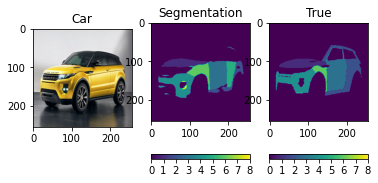

[0 1 2 3 4 5 6 8]
soft dice: tensor([[0.9495, 0.0611, 0.7924, 0.7480, 0.0570, 0.8421, 0.6267, 0.7760, 0.8553]],
       grad_fn=<DivBackward0>) <class 'torch.Tensor'>
Pixel accuracy (only the car): 90.91796875  %
dice beauty: 0.9223930203572912
Classes ground true: [0 1 2 3 4 5 6 8]
Classes predicted:  [0 2 3 5 6 7 8]


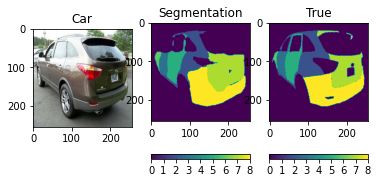

[0 2 3 5 6 7 8]
soft dice: tensor([[0.9701, 0.8316, 0.4376, 0.8601, 0.8689, 0.7993, 0.8877, 0.0164, 0.0313]],
       grad_fn=<DivBackward0>) <class 'torch.Tensor'>
Pixel accuracy (only the car): 94.37103271484375  %
dice beauty: 0.9136170065436416
Classes ground true: [0 1 2 3 4 5 6 8]
Classes predicted:  [0 1 2 3 4 5 6 7 8]


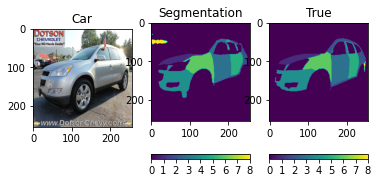

[0 1 2 3 4 5 6 7 8]
soft dice: tensor([[0.9622, 0.0113, 0.6393, 0.7559, 0.0032, 0.7368, 0.5777, 0.6842, 0.6180]],
       grad_fn=<DivBackward0>) <class 'torch.Tensor'>
Pixel accuracy (only the car): 92.35992431640625  %
dice beauty: 0.8730042359074617
Classes ground true: [0 1 2 3 4 5 6 8]
Classes predicted:  [0 1 2 3 4 5 6 7 8]


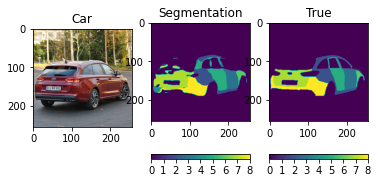

[0 1 2 3 4 5 6 7 8]
soft dice: tensor([[0.9554, 0.6342, 0.4808, 0.8488, 0.7198, 0.8184, 0.8835, 0.0026, 0.0181]],
       grad_fn=<DivBackward0>) <class 'torch.Tensor'>
Pixel accuracy (only the car): 91.34521484375  %
dice beauty: 0.8967811597163452
Classes ground true: [0 1 2 3 4 5 6 8]
Classes predicted:  [0 1 2 3 4 5 6 7 8]


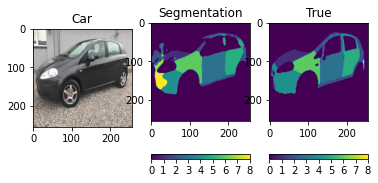

[0 1 2 3 4 5 6 7 8]
soft dice: tensor([[0.9782, 0.0261, 0.7061, 0.8176, 0.0173, 0.7901, 0.6296, 0.6443, 0.6085]],
       grad_fn=<DivBackward0>) <class 'torch.Tensor'>
Pixel accuracy (only the car): 95.4345703125  %
dice beauty: 0.8827077355507408
Classes ground true: [0 1 2 3 4 5 6 8]
Classes predicted:  [0 2 3 5 6 7 8]


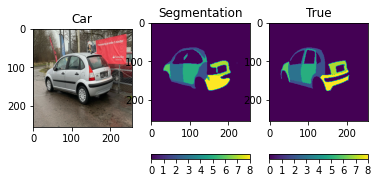

[0 2 3 5 6 7 8]
soft dice: tensor([[0.9745, 0.8221, 0.6000, 0.8638, 0.7040, 0.7937, 0.7059, 0.0487, 0.1137]],
       grad_fn=<DivBackward0>) <class 'torch.Tensor'>
Pixel accuracy (only the car): 94.921875  %
dice beauty: 0.8854525182994814
Classes ground true: [0 1 2 3 4 5 6 8]
Classes predicted:  [0 1 2 3 4 5 6 8]


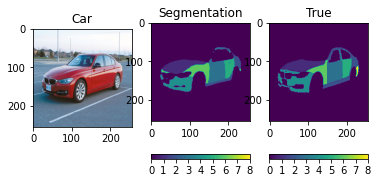

[0 1 2 3 4 5 6 8]
Table values - using the testcars
Soft diceloss mean: 0.8854522982388338
Pixel accuracy mean: 0.9203109741210938


In [20]:
#@title Test on all test images

pix_acc_epoch, dices = [], []
beauty_diceloss, pixies = [], []
for i in range(len(cars)):
      #print('### test car ' + str(i) + ' ###')
      xx=network(cars[i])

      loss_fn1 = build_losses('Dice loss')

      xx=xx[0,0:9,:,:]
      xx2 = torch.reshape(xx,(1, xx.shape[0], xx.shape[1],xx.shape[2]))
      image_ma22 = torch.from_numpy(masks[i])
      image_ma22 = Variable(image_ma22.type(torch.cuda.LongTensor))
      image_ma223 = torch.reshape(image_ma22,(1,1,image_ma22.shape[0],image_ma22.shape[1])).cpu()
      #acc_test=multi_acc(xx,image_ma22).cpu().numpy()

      loss = loss_fn1(xx2, image_ma223)

      print('soft dice:', loss, type(loss))

      xx = xx.argmax(0).cpu()
      a=image_ma22.cpu()
      b=xx.cpu()
      pix_acc= pixel_accuracy(b,a)
      pixies.append(pix_acc)
      print('Pixel accuracy (only the car):' ,pix_acc*100, ' %')

      dice_beauty=dice_coeff(a,b)
      beauty_diceloss.append(dice_beauty)
      print('dice beauty:', dice_beauty)

      print('Classes ground true:',np.unique(image_ma2))
      print('Classes predicted: ',np.unique(xx))

      fig = plt.figure()
      ax = fig.add_subplot(1, 3, 1)
      imgplot = plt.imshow(tis[i])
      ax.set_title('Car')
      ax = fig.add_subplot(1, 3, 2)
      imgplot = plt.imshow(xx)
      ax.set_title('Segmentation')
      plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10], orientation='horizontal')
      ax = fig.add_subplot(1, 3, 3)
      imgplot = plt.imshow(masks[i])
      ax.set_title('True')
      plt.colorbar( ticks=[0,1,2,3,4,5,6,7,8,9,10], orientation='horizontal')
      plt.show()

      print(np.unique(xx))
print('Table values - using the testcars')
print('Soft diceloss mean:', np.mean(beauty_diceloss))
print('Pixel accuracy mean:', np.mean(pixies))

In [ ]:
#@title Test on one image 

#true: a tensor of shape [B, 1, H, W].
#logits: a tensor of shape [B, C, H, W]



# import seaborn as sns
# from numpy import savetxt
# %matplotlib inline
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# xx=network(imgs)

# loss_fn1 = build_losses('Dice loss')


# xx=xx[0,0:9,:,:]
# xx2 = torch.reshape(xx,(1, xx.shape[0], xx.shape[1],xx.shape[2]))
# image_ma22 = torch.from_numpy(image_ma2)
# image_ma22 = Variable(image_ma22.type(torch.LongTensor))
# image_ma223 = torch.reshape(image_ma22,(1,1,image_ma22.shape[0],image_ma22.shape[1]))

# loss = loss_fn1(xx2, image_ma223)
# #dice2 =dice_loss(image_ma223,xx2)##########################

# #print('dice coeff' ,dice2)
# print('soft dice:', loss, type(loss))
# print('maybe', np.mean(loss.detach().numpy()[0][1:]))

# xx = xx.argmax(0)
# a=image_ma22
# b=xx
# pix_acc= pixel_accuracy(b,a)
# print('Pixel accuracy (only the car):' ,pix_acc*100, ' %')

# dice_beauty=dice_coeff(a,b)

print('dice beauty:', dice_beauty)


print('Classes ground true:',np.unique(image_ma2))
print('Classes predicted: ',np.unique(xx))


fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(image_ti)
ax.set_title('Car')
ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(xx)
ax.set_title('Segmentation')
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10], orientation='horizontal')
ax = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(image_ma2)
ax.set_title('True')
plt.colorbar( ticks=[0,1,2,3,4,5,6,7,8,9,10], orientation='horizontal')

print(np.unique(xx))